### Знакомство с полиномиальной регрессией 🧮
Линейная регрессия — один из самых простых и широко используемых методов, используемых для анализа данных и прогнозирования. Она позволяет моделировать линейные зависимости между переменными, представляя её в виде прямой линии. 
* Основная цель линейной регрессии — предсказать значение зависимой переменной на основе независимых, называемых факторами или более модно - фичами. 

Однако, линейная регрессия не так проста и бывает разных видов:
- 📏 _"Простая" линейная регрессия_ - регрессия с одним признаком
- 🧮 _"Многомерная" линейная регрессия_ - регрессия с несколькими признаками
- 🌀 _"Полиномиальная" регрессия_ - регрессия с несколькими признаками + степени этих признаков (полином)
- 📊 _"Регрессия Пуассона"_ - модель линейной регрессии, которая лучше работает когда целевая переменная — счётные данные (число заказов, покупок, покупателей, ...)

Линейная регрессия является отличной отправной точкой (бейзлайном) перед построением или сравнением с более сложными моделями. 

В этом ноутбуке мы познакомимся с **моделью полиномиальной  регрессии** с несколькими признаками.

In [1]:
import numpy as np
import warnings

SEED = 23
warnings.filterwarnings('ignore')

# Данные 📊
Для простого понимания алгоритма полиномиальной регрессии я предлагаю рассмотреть синтетический пример. Давай смоделируем нелинейную функцию следующего вида:

$y(x) = \cos(3\pi x)$
- $y$ - целевая переменная
- $x$ - признак

Пусть значения таргета лежат на отрезке от $[0;1]$. Также добавим шум в данные, чтобы смоделировать "реальность"

In [2]:
# устанавливаем seed для воспроизводимости результатов
np.random.seed(SEED)

# параметры для генерации синтетических данных
samples_count = 100
constant = 3
noise_ratio = 0.3

# генерируем синтетические данные (истинная зависимость)
x_true = np.linspace(0, 1, samples_count)
y_true = np.cos(constant * np.pi * x_true)

# генерируем синтетические данные (наблюдения с шумом)
X = np.random.uniform(0, 1, size=samples_count)
y = np.cos(constant * np.pi * X) + np.random.normal(scale=noise_ratio, size=X.shape)

In [3]:
import plotly.graph_objects as go

# визуализируем синтетические данные + функциональную зависимость
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_true, y=y_true, mode='lines',
    name='Истинная зависимость',
    line=dict(color='green')
))

fig.add_trace(go.Scatter(
    x=X, y=y, mode='markers',
    name='Сэмплы с шумом',
    marker=dict(color='red', size=8)
))

fig.update_layout(
    title='Нелинейная зависимость с шумом',
    xaxis_title='x',
    yaxis_title='f(x)',
    height=600,
    width=1200
)

fig.show()

Отлично, у нас есть выборка на которой мы можем обучить модель. Однако есть одно НО, зависимость между признаком и таргетом - нелинейная. Справится линейная регрессия с данной задачей? Ммм, давай проверим 🧐

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# обучим линейную регрессию
linear_regression = LinearRegression()

# не забываем, что sklearn ожидает 2D массивы для признаков (таргет может быть 1D)
X = X.reshape(-1, 1)

linear_regression.fit(X, y)
y_train_hat = linear_regression.predict(X)

# измеряем ошибку на обучающей выборке
mse_train = mean_squared_error(y, y_train_hat, squared=False)
print(f'RMSE на обучающей выборке: {mse_train:.4f}')

RMSE на обучающей выборке: 0.6882


In [5]:
# визуализируем синтетические данные + функциональную зависимость
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_true, y=y_true, mode='lines',
    name='Истинная зависимость',
    line=dict(color='green')
))

# прогноз линейной регрессии
fig.add_trace(go.Scatter(
    x=X.flatten(), y=y_train_hat, mode='lines',
    name='Линейная регрессия',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=X.flatten(), y=y, mode='markers',
    name='Сэмплы с шумом',
    marker=dict(color='red', size=8)
))


fig.update_layout(
    title='Нелинейная зависимость с шумом',
    xaxis_title='x',
    yaxis_title='f(x)',
    height=600,
    width=1200
)

fig.show()

Получилось как-то не очень 👎

Модель совершенно не предсказывает нелинейный тренд в данных. 
Все это вполне ожидаемо, ведь модель которую мы используем - линейная. Она не способна предсказывать нелинейные зависимости в данных. Однако, есть трюк, позволяющий сделать нелинейную модель из линейной - использовать полином.

### Что такое полином? 🤔📈
Полином — это математическое выражение, состоящее из суммы степеней переменной с коэффициентами. В контексте полиномиальной регрессии - это просто модель с признаками в разных степенях (квадраты, кубы, ...)

$$
\hat{y} = w_0 + w_1 x + w_2 x^2 + w_3 x^3 + \dots + w_n x^n
$$

- $x$ — входной признак  
- $x^2, x^3, x^n$ — дополнительные *степенные признаки* признака $x$
- $w_0, w_1, w_n$ — веса модели, определяемые при обучении

Так как на практике мы обычно работаем со множеством признаков, то в полином еще включают __попарное взаимодействие фичей:__

$$
\hat{y} = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_1^2 + w_4 x_2^2 + w_5 x_1 x_2 + \dots + w_n x_n + w_n x_n^n + w_n x_{1n} x_{2n}
$$

Можно сказать, что <u>полином превращает прямую в кривую</u> за счет степеней и попарных взаимодействий признаков 🧙‍♂️

In [6]:
# рассмотрим пример полинома 4 степени для наших синтетических данных

# cоздадим полиномиальные признаки 4-й степени (вручную)
X_2, X_3, X_4 = X**2, X**3, X**4

# объединим все признаки в один массив
X_poly = np.hstack((X, X_2, X_3, X_4))
X_poly = X_poly.reshape(-1, 4)

# обучим линейную регрессию
linear_regression = LinearRegression()
linear_regression.fit(X_poly, y)

# измеряем ошибку на обучающей выборке
y_train_hat = linear_regression.predict(X_poly)
mse_train = mean_squared_error(y, y_train_hat, squared=False)
print(f'RMSE на обучающей выборке: {mse_train:.4f}')

RMSE на обучающей выборке: 0.4231


In [7]:
# отсортируем значение по X (необходимо для правильной визуализации)
sorted_idx = np.argsort(X[:, 0])
x_sorted = X[sorted_idx, 0]
y_hat_sorted = y_train_hat[sorted_idx]

In [8]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_true, y=y_true, mode='lines',
    name='Истинная зависимость',
    line=dict(color='green')
))

fig.add_trace(go.Scatter(
    x=x_sorted.flatten(), y=y_hat_sorted, mode='lines',
    name='Линейная регрессия',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=X.flatten(), y=y, mode='markers',
    name='Сэмплы с шумом',
    marker=dict(color='red', size=8)
))

fig.update_layout(
    title='Полином 4-й степени',
    xaxis_title='x',
    yaxis_title='f(x)',
    height=600,
    width=1200
)

fig.show()

- Вау, теперь наша линейная модель стала предсказывать нелинейные зависимости 😲

### Полиномиальные признаки 🔢
Вместо того чтобы обучать модель на исходных признаках $X$, мы добавляем в обучающую выборку дополнительные признаки — $X²$, $X³$, $X⁴$, ... Это позволяет линейной модели находить более сложные зависимости между таргетом и фичами: квадратичные, кубические, ... и строить уже не прямую, а полином N-ой степени. Чтобы стало понятнее, давай рассмотрим вот такой пример:

**Истинная зависимость**
- $y = x²$

Это парабола, которую обычная линейная регрессия с одним признаком $x$ не сможет хорошо описать. Как бы ты не старался, ошибка будет большой. Поэтому мы можем расширить признаки - добавить новый признак $x²$

**Новая модель**:
- $\hat{y} = w_0 + w_1 \cdot x + w_2 \cdot x^2$

Так как мы уже знаем, что истинная зависимость - квадратичная, то можем предположить, что модель найдет вот такие оптимальные веса:
- $w_0≈0, w_1≈0, w_2≈1$

Она просто установит, что зависимость квадратичная и будет использовать только этот признак, а все остальные занулит!

In [9]:
# снова рассмотрим на примере
np.random.seed(SEED)

# генерируем синтетические данные
X_samples = np.linspace(-3, 3, 100)
y_squared = X_samples**2 + np.random.normal(0, 1, size=X_samples.shape)  # добавим немного шума

# добавляем квадратичный признак 
X_squared = X_samples**2
X_poly = np.column_stack((X_samples, X_squared))

# обучим модель
linear_regression = LinearRegression()
linear_regression.fit(X_poly, y_squared)

# предсказываем
y_hat = linear_regression.predict(X_poly)

In [10]:
# визуализируем
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=X_samples,
    y=y_squared,
    mode='markers',
    name='Наблюдения (Train)',
))

fig.add_trace(go.Scatter(
    x=X_samples,
    y=y_hat,
    mode='lines',
    name='Модель',
    line=dict(color='red', width=3)
))

fig.update_layout(
    title='Полиноминальня регрессия',
    xaxis_title='x',
    yaxis_title='y',
    height=800,
    width=1200
)

fig.show()

In [11]:
print("Коэффициенты модели:")
print(f"w0 (intercept): {linear_regression.intercept_:.2f}")
print(f"w1 (x):         {linear_regression.coef_[0]:.2f}")
print(f"w2 (x^2):       {linear_regression.coef_[1]:.2f}")

Коэффициенты модели:
w0 (intercept): 0.15
w1 (x):         0.05
w2 (x^2):       0.99


Действительно, модель практически не учитывает признак $x$ - вес не особо отличается от нуля. Важен только признак $x^2$. Получается, что модель поняла в процессе обучения, что лучше использовать $x^2$, так как с этим признаком ошибка будет гораздо меньше. Именно так модель определяет как признаки взаимосвязаны с целевой переменной - линейно или нелинейно. В данном случае модель определила нелинейную зависимость, а именно, квадратичную.

Получается, что можно просто дать модели набор различных признаков, а она уже сама определит что важно, а что нет. Однако не все так просто! Давай попробуем построить полиномы различной степени и смотреть как хорошо модель предсказывает данные. Для удобной генерации полиномиальных признаков рекомендую использовать [Polynomial Features](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) из _sklearn_.

In [12]:
from sklearn.preprocessing import PolynomialFeatures

# создадим полиномиальные признаки 
degree = 2
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly_features.fit_transform(X.reshape(-1, 1))

# обучим модель
linear_regression = LinearRegression()
linear_regression.fit(X_poly, y)

# оценим качество модели
y_train_hat = linear_regression.predict(X_poly)
mse_train = mean_squared_error(y, y_train_hat, squared=False)
print(f'RMSE на обучающей выборке: {mse_train:.4f}')

RMSE на обучающей выборке: 0.6844


In [13]:
# отсортируем значения по X (необходимо для правильной визуализации)
sorted_idx = np.argsort(X[:, 0])
x_sorted = X[sorted_idx, 0]
y_hat_sorted = y_train_hat[sorted_idx]

In [14]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_true, y=y_true, mode='lines',
    name='Истинная зависимость',
    line=dict(color='green')
))

fig.add_trace(go.Scatter(
    x=x_sorted.flatten(), y=y_hat_sorted, mode='lines',
    name='Линейная регрессия',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=X.flatten(), y=y, mode='markers',
    name='Сэмплы с шумом',
    marker=dict(color='red', size=8)
))

fig.update_layout(
    title=f'Полином {degree} степени',
    xaxis_title='x',
    yaxis_title='f(x)',
    height=600,
    width=1200
)

fig.show()

В этом примере хорошо видно, что полинома второй степени явно недостаточно. Да, модель уже улавливает нелинейный характер зависимости, но сама зависимость гораздо сложнее, чем простая квадратичная форма. Поэтому проведём эксперимент и построим полиномы разных степеней 📈🔢

In [15]:
from plotly.subplots import make_subplots

degrees = [1, 10, 150]
subplot_titles = [f"Степень = {d}" for d in degrees]

fig = make_subplots(rows=1, cols=3, subplot_titles=subplot_titles)
colors = dict(true='green', pred='blue', data='red')

for i, deg in enumerate(degrees):
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)

    X_poly = poly_features.fit_transform(X.reshape(-1, 1))
    X_plot_poly = poly_features.transform(x_sorted.reshape(-1, 1))

    model = LinearRegression().fit(X_poly, y)
    y_pred = model.predict(X_plot_poly)

    fig.add_trace(go.Scatter(
        x=x_sorted.flatten(), y=y_true.flatten(),
        name='Истинная зависимость', legendgroup='true', line_color=colors['true'],
        showlegend=(i == 0)
    ), 1, i+1)

    fig.add_trace(go.Scatter(
        x=x_sorted.flatten(), y=y_pred,
        name='Прогноз модели', legendgroup='pred', line_color=colors['pred'],
        showlegend=(i == 0)
    ), 1, i+1)

    
    fig.add_trace(go.Scatter(
        x=X.flatten(), y=y,
        mode='markers', name='Данные', legendgroup='data',
        marker_color=colors['data'],
        showlegend=(i == 0)
    ), 1, i+1)

fig.update_layout(
    height=600,
    width=2200,
    title="Полиномы различной степени",
)
fig.update_yaxes(range=[-2, 2])
fig.show()


Вот мы и подошли к одной из ключевых тем машинного обучения, наглядно показанной выше. Любая ML-модель в процессе обучения может оказаться в одном из трёх состояний:
- *Недообучение | Underfitting* 🟦
    - Модель слишком проста, чтобы уловить основные закономерности в данных — она захватывает лишь их малую часть. В итоге предсказания будут неточными и на обучающей, и на тестовой выборке. В нашем примере это полином степени 1: как ни крути, простая прямая не способна адекватно описать сложную нелинейную зависимость. 

- *Оптимальное обучение | Good/Right Fit* 🟩
    - Золотая середина. Модель достаточно сложна, чтобы точно предсказывать данные, но при этом не «заучивает» их. Результаты стабильны как на _train_, так и на _test_ — именно этого мы и хотим достичь при обучении. В примере это полином степени 10 — он хорошо отражает общую тенденцию, не подгоняясь под случайные колебания.
    
- *Переобучение | Overfitting* 🟥
    - А вот этот случай необходимо всегда избегать - модель просто заучивает данные, а не обобщает их. Предсказания такой модели будут точны только на _train_ (эффект "заучивания") и ужасны на _test_. В нашем примере хорошо видно, что когда полином становится очень большим, то кривая начинает проходить почти через каждую точу обучающей выборки - т.е модель начинает учить и шум в данных.

### Сложность модели ⚙️
Как ты уже видел, сложность модели влияет на качество прогнозирования. К сожалению, нельзя так просто взять и использовать самую сложную модель для любой задачи ML - можно легко переобучиться. Необходимо подходить к этому с умом и осторожностью! А что вообще такое "сложность модели"? В контексте линейных моделей это просто количество используемых фичей. Логика очень проста - чем больше фичей мы используем, тем более точнее мы можем описать предсказываемый процесс, следовательно, тем выше риск переобучения. Вот простой пример:
- _Простая модель_
    - $\hat{y} = w_0 + w_1 x$
- _Модель умеренной сложности_
    - $\hat{y} = w_0 + w_1 x_1 + ... + w_n x_n$
- _Сложная модель_
    - $\hat{y} = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_1^2 + w_4 x_2^2 + w_5 x_1 x_2 + \dots + w_n x_n + w_n x_n^n + w_n x_{1n} x_{2n}$

Разумеется, _«простая»_ или _«сложная»_ модель — понятия относительные. Даже несколько признаков могут сделать модель избыточно сложной, если сама задача проста. Из этого всего можно сделать один очень важный вывод - контролируя сложность модели, мы контролируем риск переобучения. А можем ли мы как-то регулировать сложность модели? Да - <u>использовать регуляризацию</u> 🔒

Регуляризация в ML просто вводит ограничение на размер весов модели. Например, без регуляризации веса модели могут изменяться в интервале от $(-\infty, +\infty)$, а с регуляризацией уже в **ограниченном** отрезке. Более подробно о регуляризации мы поговорим в следующем уроке ➡️

### Как правильно выбрать степень полинома? 🤔
Окей, теперь ты понимаешь что такое полиномиальная регрессия. Осталось только разобраться с правильным выбором степени. Дело в том, что _"степень полинома"_ это параметр который не "выучивается" по обучающей выборке при использовании метода _fit_ модели. Мы должны задать его сами! Да, есть параметры которые необходимо задавать вручную — **гиперпараметры**. Они задают так сказать структуру модели - ее сложность.

В следующих уроках ты познакомишься с другими моделями, более сложными: _деревья, нейронные сети, ..._ У всех них есть свои гиперпараметры, которые тоже нужно подбирать для достижения наилучшего результата. К счастью, у полиномиальной регрессии есть всего один гиперпараметр — _"степень полинома"_, что делает её идеальной для начала изучения.

Но вот теперь снова возникает интересный вопрос: "Как правильно валидировать модель при подборе гиперпараметров?"

In [16]:
# твои мысли 🧠

Проблема снова будет связана с *переобучением* модели. 
- Если ты используешь тестовую выборку, чтобы выбрать лучшую степень полинома, ты фактически подстраиваешь модель под тестовые данные. 

Ты выбираешь такую степень полинома, которая наилучшим образом подходит под конкретный тест. Очень вероятно, что в продакшн среде данные будут другими и модель будет ошибаться сильнее чем ты думаешь. Запомни, что _test_ должен оставаться «чистым» для окончательной проверки модели, иначе оценка качества скорее всего будет оптимистичной. В идеале, чем меньше ты используешь _test_ для оценки качества модели тем лучше! 

**Решение** ✅

На практике пришли к чуть более сложной схеме валидации моделей при подборе гиперпараметров:
- Разбиение данных на 3 части: _train_, _validation_, _test_
- Разбиение данных на 2 части: _train_ + cross-validation, _test_

### Разбиение на 3 части: Train → Validation → Test 🔀

_Train | Обучающая выборка_ 🏋️‍♂️
- Используется только для обучения модели — оптимизация весов

_Validation | Валидационная выборка_ ✅
- Используется только для **оценки** выбранных гиперпараметров модели
- Проверяем какая степень полинома даёт наилучший баланс между "недообучением" и "переобучением"
- Можно использовать много раз

_Test | Тестовая выборка_ 📝
- Используется в идеале <u>только один раз</u> для финальной оценки модели.
- Проверяет, насколько хорошо модель способна предсказывать новые, ранее невиданные данные - оценка обобщающей способности

Такой подход позволяет избегать переобучения на _test_ и получить реалистичную оценку качества модели. Однако, тебе необходимо "жертвовать" часть данных на _validation_, следовательно, модель обучается на меньшем наборе данных, что может приводить к потере качества прогнозирования. На практике обычно используют вот такую пропорцию разбиения данных: _~70% train ~15% validation, ~15% test_

- Как думаешь, а можно ли "отщипнуть" 15% для _validation_ не от тестовой выборки, а от обучающей? Как это повлияет на результаты?

<!-- Ответ
Для начала давай подумае, что произойдет в этих 2-х случаях:

- Вариант A: "70% train | 15% validation | 15% test" 
- Вариант B: "55% train | 15% validation | 30% test"

Основные различия - объем обучающей и тестовой выборок. Вариант B будет хорош с точки зрения более качественной валидации модели, так-как данных в test будет 30%. Однако, данных в train будет меньше 55% вместо стандартных 70%. Как уже известно, качество любой ML-модели зависит от объема обучающей выборки - чем больше данных, тем лучше. Поэтому выбор метода будет зависеть от объема данных. Если данных мало, то лучше использовать вариант A, чтобы не проседать в качестве.
-->

In [ ]:
# твои мысли 🧠

In [ ]:
# взглянем на размерность исходных данных
n_samples, n_features = X.shape
print(f"Размерность исходных данных: {n_samples} сэмплов")

Размерность исходных данных: 100 сэмплов


- Как видишь у нас маловато данных чтобы продемонстрировать как работаю разные методы валидации модели. Окей, тогда просто сгенерируем больше данных ⬆️💾

In [18]:
# устанавливаем seed для воспроизводимости результатов
np.random.seed(SEED)

# параметры для генерации синтетических данных
samples_count = 1_000
constant = 3
noise_ratio = 0.3

# генерируем синтетические данные (истинная зависимость)
x_true = np.linspace(0, 1, samples_count)
y_true = np.cos(constant * np.pi * x_true)

# генерируем синтетические данные (наблюдения с шумом)
X = np.random.uniform(0, 1, size=samples_count)
y = np.cos(constant * np.pi * X) + np.random.normal(scale=noise_ratio, size=X.shape)

In [19]:
from sklearn.model_selection import train_test_split

# сначала делим данные на train и temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=SEED)

# затем temp делим на validation и test
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

# сразу сделаем reshape для обучения модели
X_train = X_train.reshape(-1, 1)
X_validation = X_validation.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

print('Кол-во наблюдений | Все данные ->', X.shape[0])
print('Кол-во наблюдений | Train ->', X_train.shape[0])
print('Кол-во наблюдений | Validation ->', X_validation.shape[0])
print('Кол-во наблюдений | Test ->', X_test.shape[0])

Кол-во наблюдений | Все данные -> 1000
Кол-во наблюдений | Train -> 700
Кол-во наблюдений | Validation -> 150
Кол-во наблюдений | Test -> 150


In [20]:
# сделаем визуализцию полученных подвыборок для обучения и валидации
fig = make_subplots(
    rows=3, cols=1, shared_xaxes=True,
    subplot_titles=("Train", "Validation", "Test")
)

fig.add_trace(
    go.Scatter(
        x=X_train.flatten(), y=y_train, mode='markers',
        marker=dict(color='blue'), name='Train'
    ),row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=X_validation.flatten(), y=y_validation, mode='markers',
        marker=dict(color='green'), name='Validation'
    ), row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=X_test.flatten(), y=y_test, mode='markers',
        marker=dict(color='red'), name='Test'
    ), row=3, col=1
)

fig.update_layout(
    height=1000,
    width=1000,
    title_text="Данные на Train | Validation | Test"
)

fig.show()

- Хорошо заметно, что больше всего данных в _train_, _validation_ и _test_ уже имеют меньше данных - как и должно быть. Распределения всех подвыборок также совпадают

In [21]:
from sklearn.metrics import mean_absolute_error, r2_score

# задаем параметры
max_poly_degree = 15      
metric_fn = mean_squared_error
metric_name, is_rmse = "RMSE", True

best_degree = None
best_score = float("inf")
scores = []

for degree in range(1, max_poly_degree + 1):
    # создаем полиномиальные признаки
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    X_val_poly = poly_features.transform(X_validation)
    
    # обучаем
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # валидируем
    y_val_pred = model.predict(X_val_poly)
    score = metric_fn(y_validation, y_val_pred)
    if is_rmse:
        score = np.sqrt(score)
    
    scores.append(score)
        
    if score < best_score:
        best_score = score
        best_degree = degree

In [22]:
# теперь взглянем как изменялась метрика
degrees = list(range(1, max_poly_degree + 1))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=degrees,
    y=scores,
    mode="lines+markers",
    name=metric_name,
    marker=dict(size=8)
))

fig.add_vline(
    x=best_degree,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Лучшая степень = {best_degree}",
    annotation_position="top right"
)

fig.update_layout(
    height=500, width=1000,
    title=f"Зависимость {metric_name} от степени полинома",
    xaxis_title="Степень полинома",
    yaxis_title=metric_name,
    template="plotly_white"
)

fig.show()

- Существенное изменение метрики происходит до степени полинома 5. Дальнейшие увеличение степени полинома не значительно влияет на целевую метрику!

In [23]:
# теперь зная оптимальное значение степени полинома, обучаем модель на train + validation
X_train_val = np.vstack([X_train, X_validation])
y_train_val = np.hstack([y_train, y_validation])

poly_features_final = PolynomialFeatures(degree=best_degree, include_bias=False)
X_train_val_poly = poly_features_final.fit_transform(X_train_val)
X_test_poly = poly_features_final.transform(X_test)

model = LinearRegression()
model.fit(X_train_val_poly, y_train_val)

# финальная валидация на test
y_test_pred = model.predict(X_test_poly)
final_score = metric_fn(y_test, y_test_pred)
if is_rmse:
    final_score = np.sqrt(final_score)

print(f"{metric_name} на test: {final_score:.4f}")

RMSE на test: 0.2782


- Отлично, качество на _test_ даже чуть лучше чем на _validation_ - это хороший знак! Таким образом мы избежали переобучения на _test_ и определили верную степень полинома, обеспечивающую наилучшее значение целевой метрики!

### Разбиение на 2 части + кросс-валидация 🔀
Разбиение данных на две части в сочетании с кросс-валидацией — это альтернативный способ, который позволяет эффективно выбирать гиперпараметры без потери данных. В отличие от обычного подхода с _validation_, здесь мы не вычленяем отдельный кусок данных — вместо этого применяем кросс-валидацию внутри _train_, и проверяемся на _test_.

_Train | Обучающая выборка_ 🏋️‍♂️
- Используется для обучения модели и выбора гиперпараметров с помощью _кросс-валидации_

_Test | Тестовая выборка_ 📝
- Используется в идеале только один раз для финальной оценки модели.
- Проверяет, насколько хорошо модель способна предсказывать новые, невиданные данные.

### Что такое кросс-валидация? 🤔
Кросс-валидация (cross-validation) - это метод валидации ML моделей, позволяющий оценить качество не точечно, а интервально при помощи разбиения _train_ на K-блоков/частей/фолдов. Обычно такая оценка дает больше информации о качестве модели на разных подвыборках. Так как всегда используется несколько блоков - обычно 3/5/10, то кросс-валидация называется _K-Fold Cross-Validation_. Картинка ниже идеально описывает логику данного подхода.

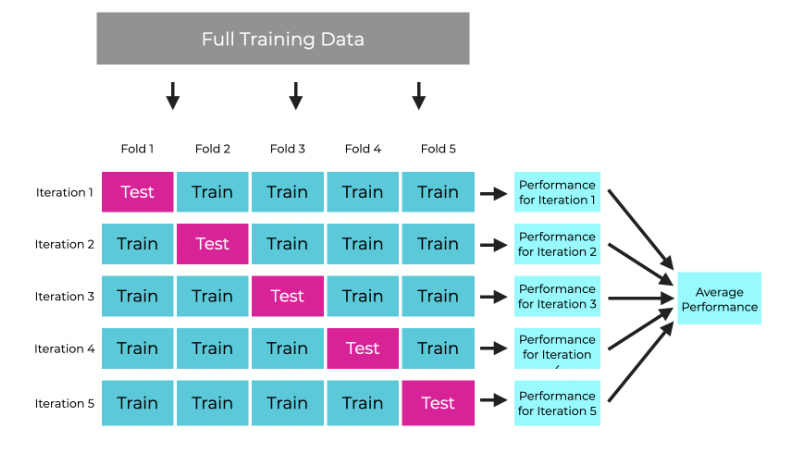

**Алгоритм** ⚙️
1. Модель обучается на всех фолдах кроме одного (тестового)
2. Тестовый фолд используется для проверки качества модели
3. Процесс повторяется до тех пор, пока каждый блок данных не побывает в _test_
4. Полученные метрики качества по фолдам усредняются

Как я уже сказал, данный метод дает больше информации о качестве модели. Например, можно измерить дисперсию целевой метрики по фолдам. Если она большая - это сигнал, что модель не способна к обобщению и слишком чувствительна к  входным данным. Такая модель будет нестабильной и совсем не будет внушать доверия. 

**Достоинства** 💪
- Позволяет получить интервальную оценку качества модели - проверка устойчивости модели
- Снижает вероятность переобучения на отдельной валидационной выборке
- Подбор гиперпарамтеров модели без потери объема данных на обучении
- Исключает оптимистичное значение метрик из-за случайного разбиения

Хочу отметить, у алгоритма кросс-валидации есть разные версии:
- Стратифицированная кросс-валидация: [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)
- Групповая кросс-валидация: [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)
- Временная кросс-валидаци: [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) 

Какую версию применять опять же зависит от задачи. Обычно если в данных нет временной зависимости то хватит _StratifiedKFold_, а если время имеет значение, то используй _TimeSeriesSplit_. Подробнее о данных методах мы поговорим в следующих уроках.

In [24]:
# снова поделим  данные на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# сразу сделаем reshape для обучения модели
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

print('Кол-во наблюдений | Все данные ->', X.shape[0])
print('Кол-во наблюдений | Train ->', X_train.shape[0])
print('Кол-во наблюдений | Test ->', X_test.shape[0])

Кол-во наблюдений | Все данные -> 1000
Кол-во наблюдений | Train -> 700
Кол-во наблюдений | Test -> 300


In [25]:
from sklearn.model_selection import KFold

# рассмотрим как работает кросс-валидация в деталях
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

for train_idx, val_idx in kf.split(X_train):
    print("Train indices:", train_idx[:5], "Validation indices:", val_idx[:5])

Train indices: [0 1 2 3 4] Validation indices: [13 14 19 21 22]
Train indices: [0 2 3 4 5] Validation indices: [ 1 11 16 17 27]
Train indices: [0 1 3 4 6] Validation indices: [ 2  5  8 10 18]
Train indices: [0 1 2 4 5] Validation indices: [ 3  9 20 28 41]
Train indices: [1 2 3 5 8] Validation indices: [ 0  4  6  7 12]


**Важно**

Как видишь, кросс-валидация просто создаёт индексы объектов для _train_ и _validation_ для каждого фолда, где индексы на _train_ и _validation_ никогда не пересекаются!

Также <u>важно использовать перемешивание выборки</u> — параметр `shuffle=True`. Это необходимо, чтобы получаемые подвыборки на каждом фолде были репрезентативными и не возникало смещения к упорядоченности данных по какому-либо признаку. Например, данные обычно выгружаются из базы данных, используя SQL-запрос. В запросах часто бывает сортировка по столбцу или столбцам, например — по зарплате сотрудника.

Если ты не используешь перемешивание, то получишь ситуацию, когда первый фолд будет содержать только низкие зарплаты, последний — только высокие или наоборот. При обучении на таких фолдах модель будет видеть только определённые сегменты зарплат, что приведёт к возникновению определённого _bias_ и большим ошибкам на валидационных подвыборках — так как распределение фичей в _train_ и _validation_ будут существенно отличаться. Другими словами, мы будем просить предсказать то, чего модель никогда не видела.

Наша цель — сделать фолды максимально похожими друг на друга или, на языке _Data Science_, сделать так, чтобы распределения признаков по фолдам совпадали! В качестве доказательства, взгляни на мой пример

In [ ]:
from sklearn.model_selection import cross_val_score

# сгенерируем данные о сотрудниках и их зарплате
np.random.seed(SEED)
samples_count = 1_000

# генерируем признаки
salary = np.linspace(30000, 150000, samples_count)
experience = (salary / 10000) + np.random.normal(0, 2, samples_count)
age = experience + 22 + np.random.normal(0, 3, samples_count)

# создадим некую зависимость с таргетом
target = 0.0002 * salary + 0.5 * experience + 0.3 * age + np.random.normal(0, 10, samples_count)
features = np.vstack([salary, experience, age]).T

# кросс-валидируем модель с перемешиванием и без
metric_name = "r2"
k_folds = 5

model = LinearRegression()

kf_no_shuffle = KFold(n_splits=k_folds, shuffle=False)
kf_shuffle = KFold(n_splits=k_folds, shuffle=True, random_state=42)

scores_no_shuffle = cross_val_score(model, features, target, cv=kf_no_shuffle, scoring=metric_name)
scores_shuffle = cross_val_score(model, features, target, cv=kf_shuffle, scoring=metric_name)

# результаты кросс-валидации
print("CV (No shuffle) -> ", scores_no_shuffle)
print("CV (Shuffle) -> ", scores_shuffle)

CV (No shuffle) ->  [0.04364    0.0208545  0.09509241 0.02688365 0.00359276]
CV (Shuffle) ->  [0.44876498 0.43760863 0.43403122 0.43922567 0.5005473 ]


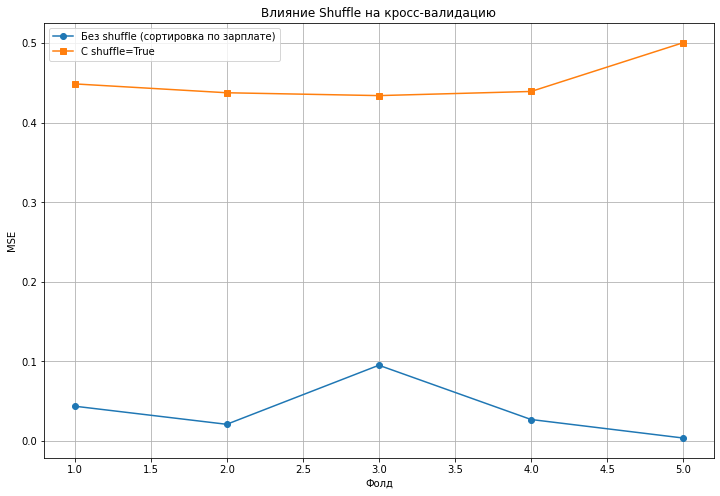

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(range(1, k_folds + 1), scores_no_shuffle, marker="o", label="Без shuffle (сортировка по зарплате)")
plt.plot(range(1, k_folds + 1), scores_shuffle, marker="s", label="С shuffle=True")
plt.xlabel("Фолд")
plt.ylabel("MSE")
plt.title("Влияние Shuffle на кросс-валидацию")
plt.legend()
plt.grid(True)
plt.show()


Качество модели с перемешиванием гораздо лучше и стабильнее. Давай взглянем как распределялись зарплаты по фолдам с перемешиванием и без

In [28]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=["Без shuffle", "С shuffle"])

for i, (_, val_idx) in enumerate(kf_no_shuffle.split(X)):
    fig.add_trace(
        go.Histogram(
            x=salary[val_idx],
            nbinsx=20,
            opacity=0.6,
            name=f"Fold {i+1}",
            legendgroup=f"Fold {i+1}"
        ),
        row=1, col=1
    )

for i, (_, val_idx) in enumerate(kf_shuffle.split(X)):
    fig.add_trace(
        go.Histogram(
            x=salary[val_idx],
            nbinsx=20,
            opacity=0.6,
            name=f"Fold {i+1}",
            legendgroup=f"Fold {i+1}",
            showlegend=False
        ),
        row=1, col=2
    )

fig.update_layout(
    title_text="Распределение зарплат по фолдам",
    barmode="overlay",
    width=1600,
    height=600
)

fig.show()

- Чётко видно, что при перемешивании каждый фолд содержит наблюдения из всего диапазона признака, тогда как без перемешивания фолды охватывают лишь его ограниченную часть, это приводит к тому, что на валидации модель получает абсолютно новые наблюдения которые никогда не видела в _train_, что ожидаемо приводит к большой ошибке в прогнозе.

Теперь, зная о некоторых "подводных камнях", определим наилучшую степень полинома, используя кросс-валидацию на _train_ и финальной валидацией на _test_. В sklearn это можно сделать нескольким способами:
- [*KFold*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
- [*Cross-Val-Score*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

Разумеется, все они приводят к идентичным результатам, от себя могу лишь сказать, что с *Cross-Val-Score* просто удобнее работать. Можно гибко передать в качестве параметров любую модель, данные, метрику и тип кросс-валидации для оценки. Это очень удобно!

In [29]:
# снова разделим данные на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# сразу сделаем reshape для обучения модели
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

print('Кол-во наблюдений | Все данные ->', X.shape[0])
print('Кол-во наблюдений | Train ->', X_train.shape[0])
print('Кол-во наблюдений | Test ->', X_test.shape[0])

Кол-во наблюдений | Все данные -> 1000
Кол-во наблюдений | Train -> 700
Кол-во наблюдений | Test -> 300


In [30]:
from sklearn.model_selection import cross_val_score

best_degree = None
best_score = float("inf")
max_poly_degree = 15
k_folds = 5
metric_name = "neg_root_mean_squared_error"
scores = []

for degree in range(1, max_poly_degree + 1):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)

    # кросс-валидируем модель
    model = LinearRegression()
    cv_scores = cross_val_score(
        model, X_train_poly, y_train, cv=k_folds, scoring=metric_name
    )
    
    mean_score = -np.mean(cv_scores)
    scores.append(mean_score)
    
    if mean_score < best_score:
        best_score = mean_score
        best_degree = degree

In [42]:
# вот так выглядят результаты кросс-валидации
print('Cross-Validation (CV) Results: ', cv_scores)
print('CV Results Mean: ', cv_scores.mean())

Cross-Validation (CV) Results:  [-0.32433367 -0.31352682 -0.29588406 -0.29392202 -0.33489157]
CV Results Mean:  -0.31251162747449807


А почему значения метрики отрицательные? RMSE ведь всегда положительна, что не так? Все дело в sklearn. Функция _cross_val_score_ под капотом автоматически обучает модель с учётом заданной метрики через параметр _scoring_ и оптимизирует модель так, чтобы эта метрика была максимальна. Окей, а почему метрика именно максимизируется?

Так как в ML-очень много различных метрик, то необходимо выбрать что-то одно (ввести стандарт), поэтому разработчики решили использовать вариант с максимизацией. Выходит чем больше получаемое значение, тем лучше. Поэтому метрики связанные с ошибкой имеют знак минус и начинаются с `neg_`, например `neg_root_mean_squared_error`

Вот простой пример. Допустим, изменения параметров модели приводили вот к таким результатам:
- [-4500, -2500, -1400, -900, -350, -300, -289, -275, ...]

Заметь, что -4500 меньше, чем -275. При использовании _cross_val_score_ алгоритм максимизирует значение метрики, поэтому будет стремиться к меньшему по модулю отрицательному числу (-275), что соответствует минимальной ошибке. После того как мы убираем знак минус, получаем положительные _RMSE_, и модель действительно имеет наименьшую ошибку на валидации. Вот и весь секрет ✨

In [47]:
# теперь взглянем как изменялось среднее значение метрики на кросс-валидации для каждой степени полинома
degrees = list(range(1, max_poly_degree + 1))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=degrees,
    y=scores,
    mode="lines+markers",
    name=metric_name,
    marker=dict(size=8)
))

fig.add_vline(
    x=best_degree,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Лучшая степень = {best_degree}",
    annotation_position="top right"
)

fig.update_layout(
    height=500, width=1000,
    title=f"Зависимость RMSE от степени полинома",
    xaxis_title="Степень полинома",
    yaxis_title="RMSE",
    template="plotly_white"
)

fig.show()

- Существенное изменение метрики происходит до степени полинома 5. Дальнейшие увеличение степени полинома не значительно влияет на целевую метрику!

In [50]:
# теперь зная оптимальное значение степени полинома, обучаем модель на train
poly_features = PolynomialFeatures(degree=best_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# финальная валидация на test
model_final = LinearRegression()
model_final.fit(X_train_poly, y_train)
y_test_pred = model_final.predict(X_test_poly)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Финальная RMSE на test: {rmse_test:.4f}")

Финальная RMSE на test: 0.2926


In [ ]:
# применим сортировку (чтобы было возможно отрисовать линию)
sort_idx = np.argsort(X_test.ravel())
X_test_sorted = X_test.ravel()[sort_idx]
y_test_sorted = y_test[sort_idx]
y_pred_sorted = y_test_pred[sort_idx]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=X_test_sorted, y=y_test_sorted,
    mode='markers',
    name='Истинная зависимость (Test)',
    line=dict(color='green', dash='dash')
))

fig.add_trace(go.Scatter(
    x=X_test_sorted, y=y_pred_sorted,
    mode='lines',
    name='Прогноз модели (Test)',
    line=dict(color='red'),
    marker=dict(size=6)
))

fig.update_layout(
    height=600, width=1500,
    title=f'Прогноз модели | Test | RMSE = {rmse_test:.4f}',
    xaxis_title='X',
    yaxis_title='y',
)

fig.show()

Отлично, качество на _test_ даже чуть лучше чем на _validation_ - это хороший знак! Таким образом мы избежали переобучения на _test_ и определили верную степень полинома, обеспечивающую наилучшее значение целевой метрики. Однако, если сравнить значение метрики с предыдущим подходом - разбиение на _train/validation/test_, то почему то у нас получилось хуже, вот результаты:
- RMSE | Test | Train/Validation/Test -> 0.2782
- RMSE | Test | Cross-validation/Test -> 0.2926

Как думаешь, в чем причина?

<!-- Ответ
Дело в том, что у нас отличается кол-во наблюдений в тестовой выборке для 2-х вариантов. Смотри
- Train/Validation/Test -> 150 наблюдений в Test
- Cross-Validation/Test -> 300 наблюдений в Test

Выходит, что при использовании кросс-валидации у тебя просто больше наблюдений в тестовой выборке, отсюда и больше ошибка!
-->

In [49]:
# твои мысли 🧠

### Задание 💪
Ниже ты найдешь код, который генерирует искуственные данные. Твоя задача - построить полиномиальную регрессию, обеспечивающую наилучшее качество на тестовой выборке.

Необходимо сделать следующие шаги 👣
- Сделай визуализацию исходных данных. Что можно сказать о наблюдаемой зависимости?
- Выбери метрику и обоснуй свой выбор
- Построй модель и провалидируй ее. Продемонстрируй, что нет переобучения
- Определи лучший гиперпараметр для модели
- Сделай финальную оценку важности признаков (график важности признаков)

**Важно** ⚠️
- Оформи задание в отдельном ноутбуке!

In [88]:
np.random.seed(SEED)

n_samples = 3000

# сгенерированные даныне
X = np.linspace(0, 1, n_samples)
X = X + np.random.normal(scale=0.02, size=X.shape)
y = 2*X**8 - 15*X**7 + 35*X**6 - 21*X**5 + 7*X**4 - 3*X**3 + 2*X**2 + np.random.normal(scale=0.05, size=X.shape)